In [5]:
# import kaggle

# kaggle.api.authenticate()

# kaggle.api.dataset_download_files('noobyogi0100/shoe-dataset', path='D:/downloads', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/noobyogi0100/shoe-dataset


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Paths to your train and val folders
train_dir = 'D:/downloads/ut-zap50k-images/ut-zap50k-images'
#val_dir = 'D:\downloads\shoeTypeClassifierDataset/validation'



transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load the training and validation datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
#val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)


# Define batch size
batch_size = 64

# Create DataLoaders for train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


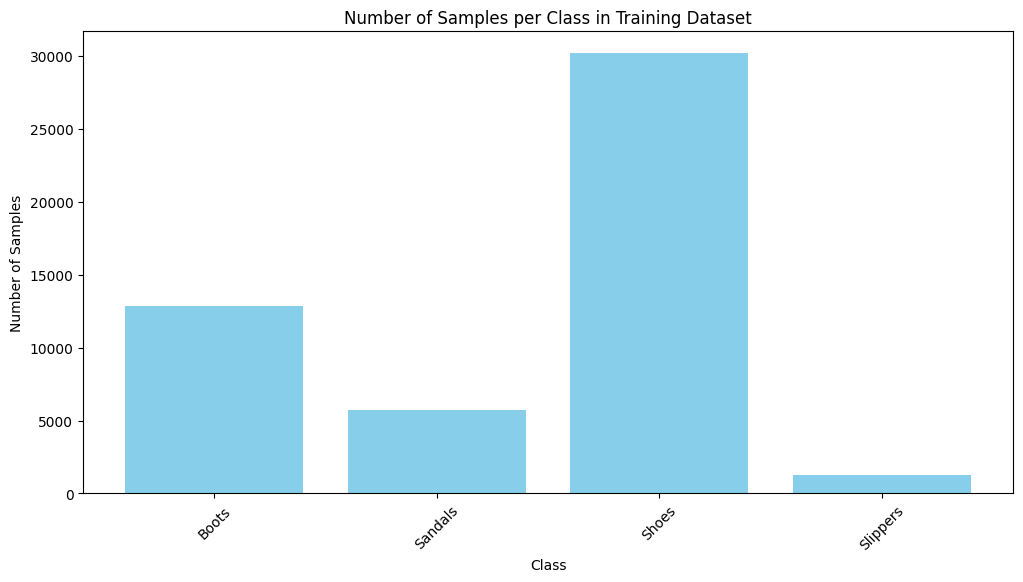

In [2]:
import matplotlib.pyplot as plt

def count_samples_per_class(dataloader, class_names):
    class_counts = {name: 0 for name in class_names}
    for _, labels in dataloader:
        for label in labels:
            class_name = class_names[label]
            class_counts[class_name] += 1
    return class_counts

class_names = train_dataset.classes

def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
    
train_class_counts = count_samples_per_class(train_loader, class_names)
# Plot the class distributions
plot_class_distribution(train_class_counts, 'Number of Samples per Class in Training Dataset')


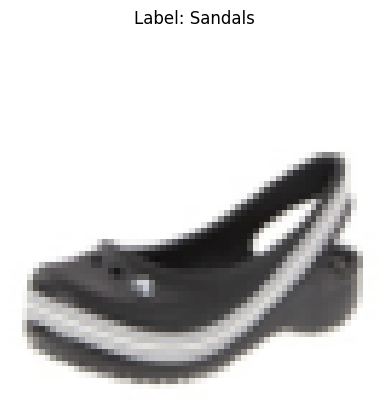

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# Function to denormalize the image for display
def denormalize(image):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = image.numpy().transpose((1, 2, 0))  # Convert tensor to NumPy array
    image = std * image + mean  # De-normalize
    image = np.clip(image, 0, 1)  # Clip pixel values to the range [0, 1]
    return image

# Get the class names from the dataset
class_names = train_dataset.classes

# Function to display an image and its label
def show_image(img, label):
    img = denormalize(img)  # De-normalize the image
    plt.imshow(img)  # Display the image
    plt.title(f'Label: {class_names[label]}')  # Show the class name as title
    plt.axis('off')  # Hide the axis
    plt.show()

# Display a single image and its label from the train_loader
for images, labels in train_loader:
    image = images[0]  # Extract the first image in the batch
    label = labels[0].item()  # Extract the label
    show_image(image, label)  # Display the image and label
    break  # Display only the first image

In [3]:
class_names

['Boots', 'Sandals', 'Shoes', 'Slippers']

In [1]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels):
        super().__init__()

        self.img_dim = channels * img_size * img_size  # Flattened image dimension
        self.label_emb = nn.Embedding(num_classes, num_classes)  # Embedding for num_classes labels (1D embedding)

        # Fully connected layers
        self.model = nn.Sequential(
            nn.Linear(self.img_dim + num_classes, 512),  # Input: flattened image + label embedding
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),  # Output: validity score
            nn.Sigmoid()  # Sigmoid to get a probability between 0 and 1
        )

    def forward(self, img, labels):
        # Flatten the image
        img_flat = img.view(img.size(0), -1)
        
        # Get the label embedding and concatenate with the image
        label_embedding = self.label_emb(labels)
        d_in = torch.cat((img_flat, label_embedding), dim=1)  # Concatenate image and label embeddings
        
        # Pass through the model
        validity = self.model(d_in)
        return validity.squeeze()

# Instantiate the linear discriminator
latent_dim = 100  # Size of the latent space (z)
num_classes = 4  # You can change this to any number of classes
img_size = 64  # Size of the image (64x64)
channels = 3  # Number of image channels (e.g., 3 for RGB, 1 for grayscale)

discriminator = Discriminator(num_classes, img_size, channels).cuda()
print(discriminator)


Discriminator(
  (label_emb): Embedding(4, 4)
  (model): Sequential(
    (0): Linear(in_features=12292, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [2]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size, channels):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)  # Embedding for num_classes labels

        # First linear layer: latent_dim + label embedding
        self.l1 = nn.Linear(latent_dim + num_classes, 1024 * 4 * 4)  # Produces 1024 x 4 x 4 feature map


        
        self.conv_blocks = nn.Sequential(
            # First transposed convolutional layer: 1024x4x4 -> 512x8x8
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # Output: 512x8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Second transposed convolutional layer: 512x8x8 -> 256x16x16
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Output: 256x16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Third transposed convolutional layer: 256x16x16 -> 128x32x32
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: 128x32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Fourth transposed convolutional layer: 128x32x32 -> 3x64x64 (RGB image)
            nn.ConvTranspose2d(128, channels, kernel_size=4, stride=2, padding=1),  # Output: 3x64x64
            nn.Tanh()  # Tanh activation for final output
        )

    def forward(self, z, labels):
        # Embed the labels and concatenate them with the latent vector
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((z, label_embedding), -1)

        # Pass the concatenated input through the first linear layer
        out = self.l1(gen_input)
        out = out.view(out.size(0), 1024, 4, 4)  # Reshape to 1024x4x4

        # Pass the result through the transposed convolutional layers
        img = self.conv_blocks(out)
        return img  # Output is (batch_size, channels, img_size, img_size)


generator = Generator(latent_dim, num_classes, img_size, channels).cuda()
print(generator)


Generator(
  (label_emb): Embedding(4, 4)
  (l1): Linear(in_features=104, out_features=16384, bias=True)
  (conv_blocks): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  

In [3]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function
criterion = nn.BCELoss()
beta1 = 0.5
beta2 = 0.999
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(beta1, beta2))
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(beta1, beta2))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable


def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, num_classes, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # Ensure real images and labels are on the same device
    real_images = real_images.to(device)
    labels = labels.to(device)

    # Train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    # Train with fake images
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, num_classes, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data
device

device(type='cuda')

In [ ]:
from tqdm import tqdm
import torch
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# General parameters
num_epochs = 700
n_critic = 5
display_step = 300
num_samples = 5  # Number of images to generate in each epoch

for epoch in range(start_epoch, num_epochs):
    print('Starting epoch {}...'.format(epoch))
    
    # Add tqdm progress bar for each batch within an epoch
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    for i, (images, labels) in progress_bar:
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        batch_size = real_images.size(0)
        
        # Training discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)

        # Training generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
        # Update progress bar description with current loss values
        progress_bar.set_description(f"[Epoch {epoch+1}/{num_epochs}] g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}")

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    # Saving the generator and discriminator models
    torch.save({
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
        'epoch': epoch  # Save the current epoch if you want to resume training
    }, 'cgan_model_shoes_v3.pth')
    
    print("Model saved successfully.")
    # Generate new sample images
    z = Variable(torch.randn(num_classes, latent_dim)).to(device)  # Generalized latent vector size
    labels = Variable(torch.LongTensor(np.arange(num_classes))).to(device)  # Generate labels for the images

    # Generate images using the generator
    sample_images = generator(z, labels).data.cpu()

    # Display the generated images in a grid
    grid = make_grid(sample_images, nrow=num_samples, normalize=True).permute(1, 2, 0).numpy()

    # Display the grid of images using matplotlib
    plt.imshow(grid)
    plt.show()


In [4]:
# Load the saved model and optimizer states if they exist
checkpoint = torch.load("cgan_model_shoes_v3.pth")

# Initialize generator and discriminator
generator = Generator(latent_dim, num_classes, img_size, channels).to(device)
discriminator = Discriminator(num_classes, img_size, channels).to(device)

# Initialize optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Load the model states
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

# Load the optimizer states if resuming training
g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])

# Load the epoch to resume training
start_epoch = checkpoint['epoch']

print(f"Resuming training from epoch {start_epoch}...")


Resuming training from epoch 611...


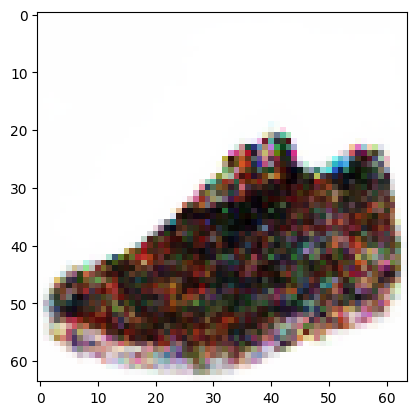

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Set generator to evaluation mode
generator.eval()

# Generate new sample images
num_samples = 1
z = torch.randn(num_samples, 100).to(device)
#labels = torch.randint(0, num_classes, (num_samples,)).to(device)  # Randomly generate labels
labels = torch.tensor([2]).to(device)  # Example: alternating labels

# Generate images
with torch.no_grad():
    sample_images = generator(z, labels).data.cpu()

# Visualize the generated images
grid = make_grid(sample_images, nrow=5, normalize=True).permute(1, 2, 0).numpy()
plt.imshow(grid)
plt.show()
